# CNN Keras Model

In [2]:
# CNN keras 모델 정의 
import gluonnlp as nlp
from torch.utils.data import Dataset
import numpy as np
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
import pandas as pd
import random

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense,Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import ElectraModel, ElectraTokenizer

model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

#dataset_train = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/prepared_train.txt', sep='\t')
#dataset_test = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/prepared_test.txt', sep='\t')
dataset_train = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/NewDataset_train.csv', sep=',')
dataset_test = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/NewDataset_test.csv', sep=',')
#dataset_train2 = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/NewNegativeDataset_train.txt', sep=',')
#dataset_test2 = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/NewNegativeDataset_test.txt', sep=',')
class ElectraDataset():
    def __init__(self, dataset_sentence, dataset_label, max_len):
        self.sentences = []
        for i in dataset_sentence:
            temp = []
            tokenid = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(i))
            #tokenidToint = [int(i) for i in tokenid]
            temp.append(tokenid)
            temp = pad_sequences(temp, maxlen = max_len)
            temp = [int(i) for i in temp[0]]
            self.sentences.append(temp)
            
        self.labels = [i for i in dataset_label]
        
        
max_len = 50
vocab_size = 35000 # KoElectra-Base-v3 vocab size : 35000

data_train = ElectraDataset(dataset_train['comment'], dataset_train['label'], max_len)
data_test = ElectraDataset(dataset_test['comment'], dataset_test['label'], max_len)
#data_train2 = ElectraDataset(dataset_train2['comment'], dataset_train2['label'], max_len)
#data_test2 = ElectraDataset(dataset_test2['comment'], dataset_test2['label'], max_len)

data_train_sentences = data_train.sentences# + data_train2.sentences
data_train_labels = data_train.labels# + data_train2.labels
data_test_sentences = data_test.sentences# + data_test2.sentences
data_test_labels = data_test.labels# + data_test2.labels

embedding_dim = 64
dropout_prob = (0.5, 0.7)
num_filters = 16

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                  kernel_size = sz,
                  padding = "valid",
                  activation = "relu", 
                  strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(32
          , activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z) # , activation="softmax"
model = Model(model_input, model_output)

Downloading: 100%|██████████| 467/467 [00:00<00:00, 137kB/s]
Downloading: 100%|██████████| 452M/452M [00:39<00:00, 11.3MB/s] 
Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['electra.embeddings.position_ids']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: 100%|██████████| 263k/263k [00:00<00:00, 294kB/s]  
Downloading: 100%|██████████| 61.0/61.0 [00:00<00:00, 13.9kB/s]


In [4]:
data_sentences = np.array(data_train_sentences + data_test_sentences)
data_labels = np.array(data_train_labels + data_test_labels)

In [5]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"]) 

# CNN_plz.h5 <- 이게 그나마 나은 버전임 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/Users/waterpurifier/CNNkeras-v1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_CNN = model.fit(data_sentences, data_labels, batch_size = 128, epochs=10, validation_split = 0.2, verbose=1, callbacks=[es, mc])
#history_CNN = model.fit(data_train_sentences, data_train_labels, batch_size = 64, epochs=10, validation_data = (data_test_sentences, data_test_labels), verbose=1, callbacks=[es, mc])

Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.4601 - acc: 0.8180
Epoch 00001: val_acc improved from -inf to 0.91302, saving model to /Users/waterpurifier/CNNkeras-v1.h5
194/194 [==============================] - 5s 28ms/step - loss: 0.4601 - acc: 0.8180 - val_loss: 0.3022 - val_acc: 0.9130
Epoch 2/10
192/194 [============================>.] - ETA: 0s - loss: 0.2368 - acc: 0.9223
Epoch 00002: val_acc improved from 0.91302 to 0.94652, saving model to /Users/waterpurifier/CNNkeras-v1.h5
194/194 [==============================] - 5s 27ms/step - loss: 0.2366 - acc: 0.9225 - val_loss: 0.1694 - val_acc: 0.9465
Epoch 3/10
192/194 [============================>.] - ETA: 0s - loss: 0.1650 - acc: 0.9461
Epoch 00003: val_acc improved from 0.94652 to 0.95200, saving model to /Users/waterpurifier/CNNkeras-v1.h5
194/194 [==============================] - 5s 28ms/step - loss: 0.1653 - acc: 0.9459 - val_loss: 0.1483 - val_acc: 0.9520
Epoch 4/10
193/194 [=======================

In [6]:
model.save('/Users/waterpurifier/CNN_newdata.h5')
loaded_model_CNN = load_model('/Users/waterpurifier/CNN_newdata.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model_CNN.evaluate(data_test.sentences, data_test.labels)[1]))

194/194 [==============================] - 0s 1ms/step - loss: 0.1504 - acc: 0.9517

 테스트 정확도 : 0.9517


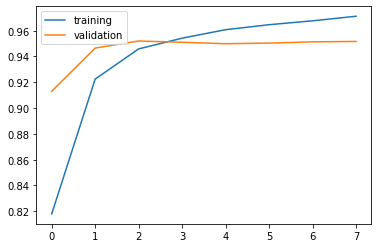

In [7]:
#CNN
import matplotlib.pyplot as plt
plt.plot(history_CNN.history['acc'])
plt.plot(history_CNN.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

# Data augmentation

In [18]:
dataAug_1 = pd.read_csv('NewNegativeData3.txt', sep='\t')
dataAug_2 = pd.read_csv('NewNegativeData2.txt', sep='\t')
dataAug_3 = pd.read_csv('NewNegativeDataset.txt', sep=',')

In [24]:
pred = []
for i in dataAug_3['comment']:
    tmp = ModelToSentence(i)
    if float(tmp.sentiment_predict()) > 0:
        pred.append(1)
    else:
        pred.append(0)


CNN : 93.54% 확률로 부정적 댓글입니다.

CNN : 96.31% 확률로 부정적 댓글입니다.

CNN : 99.67% 확률로 부정적 댓글입니다.

CNN : 99.90% 확률로 부정적 댓글입니다.

CNN : 99.68% 확률로 부정적 댓글입니다.

CNN : 95.34% 확률로 부정적 댓글입니다.

CNN : 64.03% 확률로 부정적 댓글입니다.

CNN : 65.87% 확률로 부정적 댓글입니다.

CNN : 91.05% 확률로 부정적 댓글입니다.

CNN : 99.69% 확률로 부정적 댓글입니다.

CNN : 53.22% 확률로 부정적 댓글입니다.

CNN : 99.74% 확률로 일반적 댓글입니다.

CNN : 89.33% 확률로 부정적 댓글입니다.

CNN : 98.37% 확률로 일반적 댓글입니다.

CNN : 98.48% 확률로 부정적 댓글입니다.

CNN : 92.45% 확률로 일반적 댓글입니다.

CNN : 90.46% 확률로 부정적 댓글입니다.

CNN : 95.69% 확률로 부정적 댓글입니다.

CNN : 95.11% 확률로 부정적 댓글입니다.

CNN : 98.46% 확률로 부정적 댓글입니다.

CNN : 98.11% 확률로 부정적 댓글입니다.

CNN : 98.74% 확률로 일반적 댓글입니다.

CNN : 94.98% 확률로 부정적 댓글입니다.

CNN : 96.49% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 62.26% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 53.19% 확률로 일반적 댓글입니다.

CNN : 99.49% 확률로 일반적 댓글입니다.

CNN : 85.25% 확률로 부정적 댓글입니다.

CNN : 99.62% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 88.98% 확률로 부정적 댓글입니다.

CNN : 77.58% 확

CNN : 70.11% 확률로 일반적 댓글입니다.

CNN : 97.93% 확률로 부정적 댓글입니다.

CNN : 70.11% 확률로 부정적 댓글입니다.

CNN : 99.86% 확률로 부정적 댓글입니다.

CNN : 93.87% 확률로 부정적 댓글입니다.

CNN : 96.99% 확률로 부정적 댓글입니다.

CNN : 97.44% 확률로 부정적 댓글입니다.

CNN : 86.21% 확률로 부정적 댓글입니다.

CNN : 96.86% 확률로 부정적 댓글입니다.

CNN : 74.92% 확률로 부정적 댓글입니다.

CNN : 95.28% 확률로 일반적 댓글입니다.

CNN : 94.94% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 98.61% 확률로 부정적 댓글입니다.

CNN : 80.36% 확률로 일반적 댓글입니다.

CNN : 99.90% 확률로 부정적 댓글입니다.

CNN : 90.44% 확률로 부정적 댓글입니다.

CNN : 68.69% 확률로 부정적 댓글입니다.

CNN : 99.55% 확률로 부정적 댓글입니다.

CNN : 85.74% 확률로 부정적 댓글입니다.

CNN : 98.70% 확률로 일반적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 96.14% 확률로 부정적 댓글입니다.

CNN : 81.42% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 99.34% 확률로 부정적 댓글입니다.

CNN : 85.12% 확률로 부정적 댓글입니다.

CNN : 99.69% 확률로 부정적 댓글입니다.

CNN : 98.97% 확률로 부정적 댓글입니다.

CNN : 99.75% 확률로 부정적 댓글입니다.

CNN : 99.53% 확률로 부정적 댓글입니다.

CNN : 96.02% 확률로 일반적 댓글입니다.

CNN : 98.21% 확률로 부정적 댓글입니다.

CNN : 97.21% 확률로 부정적 댓글입니다.

CNN : 95.98% 확

CNN : 70.44% 확률로 일반적 댓글입니다.

CNN : 99.74% 확률로 부정적 댓글입니다.

CNN : 93.42% 확률로 부정적 댓글입니다.

CNN : 93.62% 확률로 부정적 댓글입니다.

CNN : 63.25% 확률로 부정적 댓글입니다.

CNN : 99.47% 확률로 일반적 댓글입니다.

CNN : 99.27% 확률로 부정적 댓글입니다.

CNN : 94.98% 확률로 부정적 댓글입니다.

CNN : 63.17% 확률로 부정적 댓글입니다.

CNN : 71.71% 확률로 부정적 댓글입니다.

CNN : 98.63% 확률로 부정적 댓글입니다.

CNN : 99.68% 확률로 부정적 댓글입니다.

CNN : 97.29% 확률로 부정적 댓글입니다.

CNN : 99.53% 확률로 부정적 댓글입니다.

CNN : 78.11% 확률로 부정적 댓글입니다.

CNN : 90.05% 확률로 부정적 댓글입니다.

CNN : 81.74% 확률로 부정적 댓글입니다.

CNN : 99.52% 확률로 부정적 댓글입니다.

CNN : 92.20% 확률로 부정적 댓글입니다.

CNN : 95.06% 확률로 부정적 댓글입니다.

CNN : 93.62% 확률로 부정적 댓글입니다.

CNN : 91.69% 확률로 부정적 댓글입니다.

CNN : 99.12% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 93.18% 확률로 부정적 댓글입니다.

CNN : 98.11% 확률로 부정적 댓글입니다.

CNN : 74.58% 확률로 부정적 댓글입니다.

CNN : 97.46% 확률로 일반적 댓글입니다.

CNN : 95.75% 확률로 부정적 댓글입니다.

CNN : 97.25% 확률로 부정적 댓글입니다.

CNN : 82.18% 확률로 부정적 댓글입니다.

CNN : 60.86% 확률로 일반적 댓글입니다.

CNN : 93.51% 확률로 부정적 댓글입니다.

CNN : 75.46% 확률로 부정적 댓글입니다.

CNN : 93.35% 확

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 99.67% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 92.94% 확률로 부정적 댓글입니다.

CNN : 96.06% 확률로 부정적 댓글입니다.

CNN : 87.60% 확률로 부정적 댓글입니다.

CNN : 90.57% 확률로 부정적 댓글입니다.

CNN : 99.19% 확률로 부정적 댓글입니다.

CNN : 97.54% 확률로 일반적 댓글입니다.

CNN : 91.83% 확률로 부정적 댓글입니다.

CNN : 99.28% 확률로 부정적 댓글입니다.

CNN : 53.36% 확률로 일반적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 95.45% 확률로 부정적 댓글입니다.

CNN : 94.42% 확률로 부정적 댓글입니다.

CNN : 92.03% 확률로 부정적 댓글입니다.

CNN : 99.80% 확률로 부정적 댓글입니다.

CNN : 93.24% 확률로 부정적 댓글입니다.

CNN : 66.86% 확률로 부정적 댓글입니다.

CNN : 95.65% 확률로 부정적 댓글입니다.

CNN : 95.07% 확률로 부정적 댓글입니다.

CNN : 88.42% 확률로 부정적 댓글입니다.

CNN : 99.64% 확률로 부정적 댓글입니다.

CNN : 93.11% 확률로 부정적 댓글입니다.

CNN : 89.24% 확률로 부정적 댓글입니다.

CNN : 98.26% 확률로 부정적 댓글입니다.

CNN : 95.48% 확률로 일반적 댓글입니다.

CNN : 96.62% 확률로 부정적 댓글입니다.

CNN : 98.67% 확률로 부정적 댓글입니다.

CNN : 72.66% 확률로 일반적 댓글입니다.

CNN : 99.80% 확률로 부정적 댓글입니다.

CNN : 77.68% 확률로 일반적 댓글입니다.

CNN : 87.30% 확률로 일반적 댓글입니다.

CNN : 94.92% 확

CNN : 94.99% 확률로 부정적 댓글입니다.

CNN : 98.55% 확률로 부정적 댓글입니다.

CNN : 97.78% 확률로 부정적 댓글입니다.

CNN : 99.71% 확률로 부정적 댓글입니다.

CNN : 93.81% 확률로 부정적 댓글입니다.

CNN : 83.25% 확률로 부정적 댓글입니다.

CNN : 97.24% 확률로 부정적 댓글입니다.

CNN : 99.92% 확률로 부정적 댓글입니다.

CNN : 99.63% 확률로 부정적 댓글입니다.

CNN : 84.91% 확률로 부정적 댓글입니다.

CNN : 94.38% 확률로 부정적 댓글입니다.

CNN : 98.97% 확률로 부정적 댓글입니다.

CNN : 89.43% 확률로 부정적 댓글입니다.

CNN : 79.35% 확률로 부정적 댓글입니다.

CNN : 56.35% 확률로 부정적 댓글입니다.

CNN : 98.49% 확률로 부정적 댓글입니다.

CNN : 96.91% 확률로 부정적 댓글입니다.

CNN : 99.06% 확률로 일반적 댓글입니다.

CNN : 67.21% 확률로 부정적 댓글입니다.

CNN : 90.23% 확률로 부정적 댓글입니다.

CNN : 94.64% 확률로 부정적 댓글입니다.

CNN : 95.33% 확률로 부정적 댓글입니다.

CNN : 99.40% 확률로 부정적 댓글입니다.

CNN : 86.48% 확률로 부정적 댓글입니다.

CNN : 99.85% 확률로 부정적 댓글입니다.

CNN : 98.05% 확률로 부정적 댓글입니다.

CNN : 79.37% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 93.11% 확률로 부정적 댓글입니다.

CNN : 67.40% 확률로 부정적 댓글입니다.

CNN : 94.14% 확률로 부정적 댓글입니다.

CNN : 88.34% 확률로 부정적 댓글입니다.

CNN : 51.57% 확률로 일반적 댓글입니다.

CNN : 95.60% 확률로 부정적 댓글입니다.

CNN : 81.41% 확

CNN : 92.21% 확률로 부정적 댓글입니다.

CNN : 97.98% 확률로 일반적 댓글입니다.

CNN : 99.59% 확률로 부정적 댓글입니다.

CNN : 78.52% 확률로 부정적 댓글입니다.

CNN : 96.69% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 93.63% 확률로 부정적 댓글입니다.

CNN : 78.21% 확률로 일반적 댓글입니다.

CNN : 98.20% 확률로 부정적 댓글입니다.

CNN : 99.75% 확률로 부정적 댓글입니다.

CNN : 83.78% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 99.74% 확률로 부정적 댓글입니다.

CNN : 95.20% 확률로 일반적 댓글입니다.

CNN : 99.25% 확률로 부정적 댓글입니다.

CNN : 99.92% 확률로 부정적 댓글입니다.

CNN : 99.89% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 98.98% 확률로 부정적 댓글입니다.

CNN : 99.82% 확률로 부정적 댓글입니다.

CNN : 96.81% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 99.94% 확률로 부정적 댓글입니다.

CNN : 89.45% 확률로 부정적 댓글입니다.

CNN : 99.91% 확률로 부정적 댓글입니다.

CNN : 99.84% 확률로 부정적 댓글입니다.

CNN : 98.06% 확률로 부정적 댓글입니다.

CNN : 85.57% 확률로 부정적 댓글입니다.

CNN : 98.91% 확률로 부정적 댓글입니다.

CNN : 93.70% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 99.82% 확률로 부정적 댓글입니다.

CNN : 81.93% 확률로 부정적 댓글입니다.

CNN : 85.14%

CNN : 88.06% 확률로 부정적 댓글입니다.

CNN : 99.89% 확률로 부정적 댓글입니다.

CNN : 96.32% 확률로 부정적 댓글입니다.

CNN : 94.57% 확률로 부정적 댓글입니다.

CNN : 74.84% 확률로 부정적 댓글입니다.

CNN : 98.78% 확률로 부정적 댓글입니다.

CNN : 98.76% 확률로 부정적 댓글입니다.

CNN : 75.45% 확률로 부정적 댓글입니다.

CNN : 85.91% 확률로 부정적 댓글입니다.

CNN : 69.93% 확률로 일반적 댓글입니다.

CNN : 99.76% 확률로 부정적 댓글입니다.

CNN : 92.67% 확률로 부정적 댓글입니다.

CNN : 98.66% 확률로 부정적 댓글입니다.

CNN : 69.78% 확률로 부정적 댓글입니다.

CNN : 97.63% 확률로 부정적 댓글입니다.

CNN : 92.93% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 98.58% 확률로 부정적 댓글입니다.

CNN : 99.60% 확률로 일반적 댓글입니다.

CNN : 98.01% 확률로 부정적 댓글입니다.

CNN : 96.82% 확률로 부정적 댓글입니다.

CNN : 98.40% 확률로 부정적 댓글입니다.

CNN : 76.59% 확률로 부정적 댓글입니다.

CNN : 99.88% 확률로 부정적 댓글입니다.

CNN : 98.76% 확률로 부정적 댓글입니다.

CNN : 86.42% 확률로 부정적 댓글입니다.

CNN : 85.51% 확률로 일반적 댓글입니다.

CNN : 99.10% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.91% 확률로 부정적 댓글입니다.

CNN : 96.96% 확률로 부정적 댓글입니다.

CNN : 88.28% 확률로 부정적 댓글입니다.

CNN : 97.57% 확률로 부정적 댓글입니다.

CNN : 53.13% 확률로 일반적 댓글입니다.

CNN : 51.16% 확

CNN : 90.06% 확률로 부정적 댓글입니다.

CNN : 70.47% 확률로 부정적 댓글입니다.

CNN : 92.78% 확률로 부정적 댓글입니다.

CNN : 91.11% 확률로 부정적 댓글입니다.

CNN : 88.69% 확률로 부정적 댓글입니다.

CNN : 98.83% 확률로 일반적 댓글입니다.

CNN : 91.26% 확률로 부정적 댓글입니다.

CNN : 98.25% 확률로 부정적 댓글입니다.

CNN : 97.01% 확률로 부정적 댓글입니다.

CNN : 99.47% 확률로 부정적 댓글입니다.

CNN : 97.89% 확률로 부정적 댓글입니다.

CNN : 91.51% 확률로 일반적 댓글입니다.

CNN : 95.14% 확률로 부정적 댓글입니다.

CNN : 97.57% 확률로 부정적 댓글입니다.

CNN : 85.20% 확률로 부정적 댓글입니다.

CNN : 93.84% 확률로 부정적 댓글입니다.

CNN : 89.68% 확률로 부정적 댓글입니다.

CNN : 69.75% 확률로 부정적 댓글입니다.

CNN : 90.65% 확률로 부정적 댓글입니다.

CNN : 99.32% 확률로 부정적 댓글입니다.

CNN : 93.38% 확률로 부정적 댓글입니다.

CNN : 97.42% 확률로 부정적 댓글입니다.

CNN : 93.87% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.34% 확률로 부정적 댓글입니다.

CNN : 99.85% 확률로 부정적 댓글입니다.

CNN : 99.66% 확률로 부정적 댓글입니다.

CNN : 97.86% 확률로 부정적 댓글입니다.

CNN : 99.53% 확률로 부정적 댓글입니다.

CNN : 95.64% 확률로 부정적 댓글입니다.

CNN : 98.48% 확률로 부정적 댓글입니다.

CNN : 97.88% 확률로 일반적 댓글입니다.

CNN : 97.74% 확률로 부정적 댓글입니다.

CNN : 89.14% 확률로 부정적 댓글입니다.

CNN : 99.72% 확

CNN : 84.49% 확률로 부정적 댓글입니다.

CNN : 92.16% 확률로 부정적 댓글입니다.

CNN : 94.59% 확률로 부정적 댓글입니다.

CNN : 98.08% 확률로 부정적 댓글입니다.

CNN : 91.80% 확률로 부정적 댓글입니다.

CNN : 92.51% 확률로 부정적 댓글입니다.

CNN : 71.85% 확률로 부정적 댓글입니다.

CNN : 99.73% 확률로 부정적 댓글입니다.

CNN : 94.46% 확률로 부정적 댓글입니다.

CNN : 99.69% 확률로 부정적 댓글입니다.

CNN : 81.81% 확률로 부정적 댓글입니다.

CNN : 93.91% 확률로 부정적 댓글입니다.

CNN : 99.63% 확률로 부정적 댓글입니다.

CNN : 99.86% 확률로 부정적 댓글입니다.

CNN : 96.88% 확률로 부정적 댓글입니다.

CNN : 99.87% 확률로 부정적 댓글입니다.

CNN : 80.98% 확률로 부정적 댓글입니다.

CNN : 99.01% 확률로 부정적 댓글입니다.

CNN : 73.98% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 95.45% 확률로 부정적 댓글입니다.

CNN : 97.56% 확률로 부정적 댓글입니다.

CNN : 86.19% 확률로 부정적 댓글입니다.

CNN : 99.21% 확률로 부정적 댓글입니다.

CNN : 95.44% 확률로 부정적 댓글입니다.

CNN : 93.07% 확률로 부정적 댓글입니다.

CNN : 99.18% 확률로 부정적 댓글입니다.

CNN : 96.02% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 94.96% 확률로 부정적 댓글입니다.

CNN : 93.11% 확률로 부정적 댓글입니다.

CNN : 64.23% 확률로 일반적 댓글입니다.

CNN : 97.54% 확률로 부정적 댓글입니다.

CNN : 97.33% 확률로 부정적 댓글입니다.

CNN : 99.99% 확

CNN : 96.13% 확률로 부정적 댓글입니다.

CNN : 96.83% 확률로 부정적 댓글입니다.

CNN : 99.79% 확률로 부정적 댓글입니다.

CNN : 73.20% 확률로 부정적 댓글입니다.

CNN : 52.77% 확률로 일반적 댓글입니다.

CNN : 98.98% 확률로 부정적 댓글입니다.

CNN : 99.94% 확률로 부정적 댓글입니다.

CNN : 71.85% 확률로 부정적 댓글입니다.

CNN : 99.84% 확률로 부정적 댓글입니다.

CNN : 99.35% 확률로 부정적 댓글입니다.

CNN : 99.87% 확률로 부정적 댓글입니다.

CNN : 98.48% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 98.99% 확률로 부정적 댓글입니다.

CNN : 97.19% 확률로 부정적 댓글입니다.

CNN : 92.51% 확률로 부정적 댓글입니다.

CNN : 95.75% 확률로 부정적 댓글입니다.

CNN : 98.33% 확률로 부정적 댓글입니다.

CNN : 95.43% 확률로 부정적 댓글입니다.

CNN : 99.88% 확률로 부정적 댓글입니다.

CNN : 98.60% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.07% 확률로 일반적 댓글입니다.

CNN : 91.80% 확률로 부정적 댓글입니다.

CNN : 99.87% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 80.75% 확률로 부정적 댓글입니다.

CNN : 77.83% 확률로 부정적 댓글입니다.

CNN : 85.37% 확률로 부정적 댓글입니다.

CNN : 96.55% 확률로 부정적 댓글입니다.

CNN : 75.74% 확률로 부정적 댓글입니다.

CNN : 99.10% 확률로 부정적 댓글입니다.

CNN : 84.20% 확률로 부정적 댓글입니다.

CNN : 97.97% 확률로 부정적 댓글입니다.

CNN : 85.32% 

CNN : 99.79% 확률로 부정적 댓글입니다.

CNN : 94.08% 확률로 부정적 댓글입니다.

CNN : 85.15% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 99.33% 확률로 일반적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 96.59% 확률로 부정적 댓글입니다.

CNN : 76.66% 확률로 부정적 댓글입니다.

CNN : 99.04% 확률로 부정적 댓글입니다.

CNN : 57.73% 확률로 부정적 댓글입니다.

CNN : 91.71% 확률로 부정적 댓글입니다.

CNN : 89.44% 확률로 부정적 댓글입니다.

CNN : 99.35% 확률로 부정적 댓글입니다.

CNN : 99.80% 확률로 부정적 댓글입니다.

CNN : 99.61% 확률로 부정적 댓글입니다.

CNN : 93.30% 확률로 부정적 댓글입니다.

CNN : 99.82% 확률로 부정적 댓글입니다.

CNN : 91.69% 확률로 부정적 댓글입니다.

CNN : 87.74% 확률로 부정적 댓글입니다.

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 98.91% 확률로 부정적 댓글입니다.

CNN : 85.42% 확률로 부정적 댓글입니다.

CNN : 84.24% 확률로 부정적 댓글입니다.

CNN : 95.45% 확률로 부정적 댓글입니다.

CNN : 77.66% 확률로 부정적 댓글입니다.

CNN : 93.35% 확률로 부정적 댓글입니다.

CNN : 98.97% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 98.63% 확률로 부정적 댓글입니다.

CNN : 88.35% 확률로 부정적 댓글입니다.

CNN : 98.75% 확률로 부정적 댓글입니다.

CNN : 99.54% 확률로 일반적 댓글입니다.

CNN : 93.52% 확률로 부정적 댓글입니다.

CNN : 98.96% 확률로 부정적 댓글입니다.

CNN : 88.52% 

CNN : 99.01% 확률로 부정적 댓글입니다.

CNN : 99.42% 확률로 부정적 댓글입니다.

CNN : 65.67% 확률로 일반적 댓글입니다.

CNN : 79.36% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 93.95% 확률로 부정적 댓글입니다.

CNN : 99.85% 확률로 부정적 댓글입니다.

CNN : 97.87% 확률로 부정적 댓글입니다.

CNN : 99.77% 확률로 부정적 댓글입니다.

CNN : 86.76% 확률로 부정적 댓글입니다.

CNN : 69.24% 확률로 부정적 댓글입니다.

CNN : 99.72% 확률로 부정적 댓글입니다.

CNN : 96.94% 확률로 부정적 댓글입니다.

CNN : 98.63% 확률로 부정적 댓글입니다.

CNN : 71.81% 확률로 부정적 댓글입니다.

CNN : 76.72% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 78.21% 확률로 부정적 댓글입니다.

CNN : 98.42% 확률로 부정적 댓글입니다.

CNN : 99.38% 확률로 부정적 댓글입니다.

CNN : 99.94% 확률로 부정적 댓글입니다.

CNN : 57.44% 확률로 일반적 댓글입니다.

CNN : 71.22% 확률로 부정적 댓글입니다.

CNN : 74.99% 확률로 일반적 댓글입니다.

CNN : 88.90% 확률로 부정적 댓글입니다.

CNN : 94.32% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 78.56% 확률로 부정적 댓글입니다.

CNN : 70.07% 확률로 부정적 댓글입니다.

CNN : 92.30% 확률로 부정적 댓글입니다.

CNN : 73.74% 확률로 부정적 댓글입니다.

CNN : 95.13% 확률로 부정적 댓글입니다.

CNN : 99.75% 확률로 부정적 댓글입니다.

CNN : 97.70% 확률로 일반적 댓글입니다.

CNN : 93.12% 확

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 99.60% 확률로 부정적 댓글입니다.

CNN : 82.58% 확률로 부정적 댓글입니다.

CNN : 64.32% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 94.90% 확률로 부정적 댓글입니다.

CNN : 98.44% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 92.58% 확률로 부정적 댓글입니다.

CNN : 98.99% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.21% 확률로 부정적 댓글입니다.

CNN : 72.30% 확률로 부정적 댓글입니다.

CNN : 99.60% 확률로 부정적 댓글입니다.

CNN : 98.26% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 98.87% 확률로 부정적 댓글입니다.

CNN : 99.80% 확률로 부정적 댓글입니다.

CNN : 89.78% 확률로 부정적 댓글입니다.

CNN : 94.07% 확률로 부정적 댓글입니다.

CNN : 95.77% 확률로 부정적 댓글입니다.

CNN : 81.77% 확률로 부정적 댓글입니다.

CNN : 93.44% 확률로 부정적 댓글입니다.

CNN : 99.05% 확률로 부정적 댓글입니다.

CNN : 79.52% 확률로 부정적 댓글입니다.

CNN : 91.68% 확률로 부정적 댓글입니다.

CNN : 92.39% 확률로 부정적 댓글입니다.

CNN : 96.69% 확률로 일반적 댓글입니다.

CNN : 98.72% 확률로 부정적 댓글입니다.

CNN : 98.38% 확률로 부정적 댓글입니다.

CNN : 98.75% 확률로 부정적 댓글입니다.

CNN : 52.92% 확률로 일반적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 98.11% 확

CNN : 96.49% 확률로 부정적 댓글입니다.

CNN : 98.39% 확률로 부정적 댓글입니다.

CNN : 94.09% 확률로 부정적 댓글입니다.

CNN : 91.92% 확률로 부정적 댓글입니다.

CNN : 99.57% 확률로 일반적 댓글입니다.

CNN : 95.11% 확률로 부정적 댓글입니다.

CNN : 99.21% 확률로 일반적 댓글입니다.

CNN : 99.92% 확률로 부정적 댓글입니다.

CNN : 93.21% 확률로 부정적 댓글입니다.

CNN : 99.94% 확률로 부정적 댓글입니다.

CNN : 99.88% 확률로 부정적 댓글입니다.

CNN : 98.84% 확률로 부정적 댓글입니다.

CNN : 82.62% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.02% 확률로 부정적 댓글입니다.

CNN : 98.50% 확률로 부정적 댓글입니다.

CNN : 72.81% 확률로 부정적 댓글입니다.

CNN : 79.92% 확률로 부정적 댓글입니다.

CNN : 99.91% 확률로 부정적 댓글입니다.

CNN : 97.62% 확률로 부정적 댓글입니다.

CNN : 84.94% 확률로 일반적 댓글입니다.

CNN : 96.47% 확률로 부정적 댓글입니다.

CNN : 91.72% 확률로 부정적 댓글입니다.

CNN : 92.33% 확률로 부정적 댓글입니다.

CNN : 89.95% 확률로 부정적 댓글입니다.

CNN : 83.03% 확률로 부정적 댓글입니다.

CNN : 98.74% 확률로 부정적 댓글입니다.

CNN : 93.17% 확률로 일반적 댓글입니다.

CNN : 96.73% 확률로 부정적 댓글입니다.

CNN : 99.50% 확률로 부정적 댓글입니다.

CNN : 98.09% 확률로 부정적 댓글입니다.

CNN : 80.78% 확률로 부정적 댓글입니다.

CNN : 95.79% 확률로 일반적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 60.88% 확

CNN : 74.69% 확률로 부정적 댓글입니다.

CNN : 82.85% 확률로 부정적 댓글입니다.

CNN : 98.10% 확률로 부정적 댓글입니다.

CNN : 96.04% 확률로 부정적 댓글입니다.

CNN : 94.25% 확률로 부정적 댓글입니다.

CNN : 99.56% 확률로 부정적 댓글입니다.

CNN : 98.56% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 99.86% 확률로 부정적 댓글입니다.

CNN : 91.90% 확률로 부정적 댓글입니다.

CNN : 96.34% 확률로 부정적 댓글입니다.

CNN : 97.92% 확률로 부정적 댓글입니다.

CNN : 93.86% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.85% 확률로 부정적 댓글입니다.

CNN : 84.55% 확률로 부정적 댓글입니다.

CNN : 89.29% 확률로 부정적 댓글입니다.

CNN : 98.66% 확률로 부정적 댓글입니다.

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 97.43% 확률로 부정적 댓글입니다.

CNN : 99.25% 확률로 부정적 댓글입니다.

CNN : 99.24% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 53.81% 확률로 부정적 댓글입니다.

CNN : 97.74% 확률로 부정적 댓글입니다.

CNN : 83.12% 확률로 부정적 댓글입니다.

CNN : 98.22% 확률로 부정적 댓글입니다.

CNN : 98.78% 확률로 부정적 댓글입니다.

CNN : 96.20% 확률로 부정적 댓글입니다.

CNN : 94.80% 확률로 부정적 댓글입니다.

CNN : 94.99% 확률로 부정적 댓글입니다.

CNN : 87.94% 확률로 부정적 댓글입니다.

CNN : 98.68% 확률로 일반적 댓글입니다.

CNN : 99.52% 확률로 일반적 댓글입니다.

CNN : 94.38% 

CNN : 92.11% 확률로 부정적 댓글입니다.

CNN : 98.45% 확률로 부정적 댓글입니다.

CNN : 92.88% 확률로 부정적 댓글입니다.

CNN : 92.33% 확률로 부정적 댓글입니다.

CNN : 91.17% 확률로 부정적 댓글입니다.

CNN : 97.80% 확률로 부정적 댓글입니다.

CNN : 85.99% 확률로 일반적 댓글입니다.

CNN : 99.76% 확률로 부정적 댓글입니다.

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 96.55% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 82.17% 확률로 부정적 댓글입니다.

CNN : 99.50% 확률로 부정적 댓글입니다.

CNN : 72.39% 확률로 부정적 댓글입니다.

CNN : 93.11% 확률로 일반적 댓글입니다.

CNN : 87.98% 확률로 부정적 댓글입니다.

CNN : 78.55% 확률로 부정적 댓글입니다.

CNN : 97.94% 확률로 부정적 댓글입니다.

CNN : 97.55% 확률로 부정적 댓글입니다.

CNN : 91.86% 확률로 부정적 댓글입니다.

CNN : 95.23% 확률로 부정적 댓글입니다.

CNN : 76.62% 확률로 일반적 댓글입니다.

CNN : 93.30% 확률로 부정적 댓글입니다.

CNN : 99.79% 확률로 부정적 댓글입니다.

CNN : 92.50% 확률로 부정적 댓글입니다.

CNN : 97.12% 확률로 부정적 댓글입니다.

CNN : 97.90% 확률로 부정적 댓글입니다.

CNN : 92.53% 확률로 부정적 댓글입니다.

CNN : 77.84% 확률로 부정적 댓글입니다.

CNN : 91.04% 확률로 부정적 댓글입니다.

CNN : 90.69% 확률로 부정적 댓글입니다.

CNN : 97.59% 확률로 부정적 댓글입니다.

CNN : 86.59% 확률로 부정적 댓글입니다.

CNN : 85.72% 확률로 부정적 댓글입니다.

CNN : 78.78% 확

CNN : 94.72% 확률로 부정적 댓글입니다.

CNN : 62.42% 확률로 일반적 댓글입니다.

CNN : 95.83% 확률로 부정적 댓글입니다.

CNN : 63.43% 확률로 일반적 댓글입니다.

CNN : 95.94% 확률로 부정적 댓글입니다.

CNN : 99.27% 확률로 부정적 댓글입니다.

CNN : 97.20% 확률로 부정적 댓글입니다.

CNN : 97.37% 확률로 부정적 댓글입니다.

CNN : 91.76% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 91.09% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.67% 확률로 부정적 댓글입니다.

CNN : 99.24% 확률로 부정적 댓글입니다.

CNN : 97.89% 확률로 부정적 댓글입니다.

CNN : 93.34% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 97.37% 확률로 부정적 댓글입니다.

CNN : 72.94% 확률로 부정적 댓글입니다.

CNN : 89.81% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 93.53% 확률로 부정적 댓글입니다.

CNN : 98.65% 확률로 부정적 댓글입니다.

CNN : 96.44% 확률로 부정적 댓글입니다.

CNN : 98.51% 확률로 부정적 댓글입니다.

CNN : 99.76% 확률로 부정적 댓글입니다.

CNN : 95.03% 확률로 일반적 댓글입니다.

CNN : 82.33% 확률로 부정적 댓글입니다.

CNN : 99.59% 확률로 부정적 댓글입니다.

CNN : 94.76% 확률로 부정적 댓글입니다.

CNN : 97.21% 확률로 부정적 댓글입니다.

CNN : 93.43% 확률로 부정적 댓글입니다.

CNN : 89.06% 확률로 부정적 댓글입니다.

CNN : 77.97% 확률로 일반적 댓글입니다.

CNN : 91.58% 확

CNN : 99.80% 확률로 부정적 댓글입니다.

CNN : 93.61% 확률로 일반적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 95.78% 확률로 부정적 댓글입니다.

CNN : 95.05% 확률로 부정적 댓글입니다.

CNN : 94.98% 확률로 부정적 댓글입니다.

CNN : 99.37% 확률로 부정적 댓글입니다.

CNN : 77.55% 확률로 일반적 댓글입니다.

CNN : 99.87% 확률로 부정적 댓글입니다.

CNN : 86.06% 확률로 부정적 댓글입니다.

CNN : 95.58% 확률로 부정적 댓글입니다.

CNN : 98.70% 확률로 부정적 댓글입니다.

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 98.72% 확률로 부정적 댓글입니다.

CNN : 96.33% 확률로 부정적 댓글입니다.

CNN : 98.00% 확률로 부정적 댓글입니다.

CNN : 84.91% 확률로 부정적 댓글입니다.

CNN : 97.48% 확률로 부정적 댓글입니다.

CNN : 74.56% 확률로 부정적 댓글입니다.

CNN : 98.84% 확률로 부정적 댓글입니다.

CNN : 63.82% 확률로 부정적 댓글입니다.

CNN : 99.82% 확률로 부정적 댓글입니다.

CNN : 99.49% 확률로 부정적 댓글입니다.

CNN : 97.53% 확률로 부정적 댓글입니다.

CNN : 92.35% 확률로 부정적 댓글입니다.

CNN : 91.50% 확률로 부정적 댓글입니다.

CNN : 99.47% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 81.37% 확률로 부정적 댓글입니다.

CNN : 94.02% 확률로 부정적 댓글입니다.

CNN : 99.80% 확률로 부정적 댓글입니다.

CNN : 99.90% 확률로 부정적 댓글입니다.

CNN : 99.65% 확률로 부정적 댓글입니다.

CNN : 90.24% 확률로 부정적 댓글입니다.

CNN : 98.38% 

CNN : 93.28% 확률로 부정적 댓글입니다.

CNN : 92.58% 확률로 부정적 댓글입니다.

CNN : 90.31% 확률로 부정적 댓글입니다.

CNN : 89.16% 확률로 부정적 댓글입니다.

CNN : 96.86% 확률로 부정적 댓글입니다.

CNN : 81.62% 확률로 부정적 댓글입니다.

CNN : 81.81% 확률로 일반적 댓글입니다.

CNN : 99.94% 확률로 부정적 댓글입니다.

CNN : 96.30% 확률로 부정적 댓글입니다.

CNN : 93.65% 확률로 부정적 댓글입니다.

CNN : 98.86% 확률로 부정적 댓글입니다.

CNN : 93.67% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.51% 확률로 부정적 댓글입니다.

CNN : 82.72% 확률로 부정적 댓글입니다.

CNN : 80.57% 확률로 일반적 댓글입니다.

CNN : 96.17% 확률로 부정적 댓글입니다.

CNN : 97.19% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 83.75% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.89% 확률로 부정적 댓글입니다.

CNN : 99.51% 확률로 부정적 댓글입니다.

CNN : 57.11% 확률로 부정적 댓글입니다.

CNN : 74.03% 확률로 부정적 댓글입니다.

CNN : 60.60% 확률로 일반적 댓글입니다.

CNN : 97.29% 확률로 부정적 댓글입니다.

CNN : 74.12% 확률로 부정적 댓글입니다.

CNN : 97.42% 확률로 부정적 댓글입니다.

CNN : 95.76% 확률로 부정적 댓글입니다.

CNN : 82.21% 확률로 부정적 댓글입니다.

CNN : 99.92% 확률로 부정적 댓글입니다.

CNN : 98.31% 확률로 부정적 댓글입니다.

CNN : 84.34% 확률로 부정적 댓글입니다.

CNN : 99.70% 

CNN : 61.47% 확률로 부정적 댓글입니다.

CNN : 95.36% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 81.74% 확률로 부정적 댓글입니다.

CNN : 92.49% 확률로 부정적 댓글입니다.

CNN : 95.76% 확률로 부정적 댓글입니다.

CNN : 88.58% 확률로 부정적 댓글입니다.

CNN : 94.54% 확률로 부정적 댓글입니다.

CNN : 78.84% 확률로 부정적 댓글입니다.

CNN : 98.88% 확률로 부정적 댓글입니다.

CNN : 99.30% 확률로 부정적 댓글입니다.

CNN : 95.28% 확률로 부정적 댓글입니다.

CNN : 98.97% 확률로 부정적 댓글입니다.

CNN : 96.49% 확률로 부정적 댓글입니다.

CNN : 90.35% 확률로 부정적 댓글입니다.

CNN : 81.78% 확률로 일반적 댓글입니다.

CNN : 99.59% 확률로 부정적 댓글입니다.

CNN : 96.52% 확률로 일반적 댓글입니다.

CNN : 65.48% 확률로 부정적 댓글입니다.

CNN : 61.27% 확률로 부정적 댓글입니다.

CNN : 98.69% 확률로 부정적 댓글입니다.

CNN : 99.68% 확률로 부정적 댓글입니다.

CNN : 97.97% 확률로 부정적 댓글입니다.

CNN : 76.67% 확률로 부정적 댓글입니다.

CNN : 99.89% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.24% 확률로 부정적 댓글입니다.

CNN : 85.84% 확률로 부정적 댓글입니다.

CNN : 93.83% 확률로 부정적 댓글입니다.

CNN : 97.71% 확률로 부정적 댓글입니다.

CNN : 96.34% 확률로 부정적 댓글입니다.

CNN : 97.83% 확률로 부정적 댓글입니다.

CNN : 63.80% 확률로 일반적 댓글입니다.

CNN : 99.91% 확률로 부정적 댓글입니다.

CNN : 97.00% 확

CNN : 62.16% 확률로 부정적 댓글입니다.

CNN : 96.58% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 82.86% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 89.24% 확률로 부정적 댓글입니다.

CNN : 95.12% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.85% 확률로 부정적 댓글입니다.

CNN : 90.21% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 95.74% 확률로 부정적 댓글입니다.

CNN : 82.74% 확률로 부정적 댓글입니다.

CNN : 97.13% 확률로 부정적 댓글입니다.

CNN : 94.14% 확률로 부정적 댓글입니다.

CNN : 98.69% 확률로 부정적 댓글입니다.

CNN : 98.49% 확률로 부정적 댓글입니다.

CNN : 98.43% 확률로 일반적 댓글입니다.

CNN : 99.44% 확률로 부정적 댓글입니다.

CNN : 96.65% 확률로 부정적 댓글입니다.

CNN : 98.97% 확률로 부정적 댓글입니다.

CNN : 99.90% 확률로 부정적 댓글입니다.

CNN : 84.03% 확률로 부정적 댓글입니다.

CNN : 95.17% 확률로 부정적 댓글입니다.

CNN : 96.31% 확률로 부정적 댓글입니다.

CNN : 99.03% 확률로 부정적 댓글입니다.

CNN : 96.63% 확률로 부정적 댓글입니다.

CNN : 67.92% 확률로 부정적 댓글입니다.

CNN : 84.37% 확률로 부정적 댓글입니다.

CNN : 99.06% 확률로 부정적 댓글입니다.

CNN : 99.94% 확률로 부정적 댓글입니다.

CNN : 54.27% 확률로 일반적 댓글입니다.

CNN : 95.87% 확률로 부정적 댓글입니다.

CNN : 96.05% 확률로 부정적 댓글입니다.

CNN : 69.74% 확

CNN : 94.69% 확률로 부정적 댓글입니다.

CNN : 89.83% 확률로 부정적 댓글입니다.

CNN : 92.70% 확률로 부정적 댓글입니다.

CNN : 96.33% 확률로 부정적 댓글입니다.

CNN : 97.74% 확률로 부정적 댓글입니다.

CNN : 88.30% 확률로 부정적 댓글입니다.

CNN : 98.50% 확률로 부정적 댓글입니다.

CNN : 94.80% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.31% 확률로 부정적 댓글입니다.

CNN : 98.81% 확률로 부정적 댓글입니다.

CNN : 61.10% 확률로 부정적 댓글입니다.

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 96.61% 확률로 부정적 댓글입니다.

CNN : 72.88% 확률로 부정적 댓글입니다.

CNN : 99.92% 확률로 부정적 댓글입니다.

CNN : 94.98% 확률로 부정적 댓글입니다.

CNN : 99.84% 확률로 부정적 댓글입니다.

CNN : 97.40% 확률로 부정적 댓글입니다.

CNN : 83.76% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 99.37% 확률로 부정적 댓글입니다.

CNN : 99.25% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 98.35% 확률로 부정적 댓글입니다.

CNN : 72.27% 확률로 부정적 댓글입니다.

CNN : 99.97% 확률로 부정적 댓글입니다.

CNN : 99.95% 확률로 부정적 댓글입니다.

CNN : 86.05% 확률로 부정적 댓글입니다.

CNN : 98.39% 확률로 부정적 댓글입니다.

CNN : 63.65% 확률로 일반적 댓글입니다.

CNN : 85.51% 확률로 부정적 댓글입니다.

CNN : 98.91% 확률로 부정적 댓글입니다.

CNN : 89.56% 확률로 부정적 댓글입니다.

CNN : 98.99% 

CNN : 99.32% 확률로 부정적 댓글입니다.

CNN : 82.47% 확률로 일반적 댓글입니다.

CNN : 92.45% 확률로 부정적 댓글입니다.

CNN : 96.26% 확률로 부정적 댓글입니다.

CNN : 94.42% 확률로 부정적 댓글입니다.

CNN : 85.57% 확률로 부정적 댓글입니다.

CNN : 92.37% 확률로 부정적 댓글입니다.

CNN : 93.93% 확률로 부정적 댓글입니다.

CNN : 73.81% 확률로 부정적 댓글입니다.

CNN : 76.48% 확률로 부정적 댓글입니다.

CNN : 93.80% 확률로 부정적 댓글입니다.

CNN : 100.00% 확률로 부정적 댓글입니다.

CNN : 55.81% 확률로 부정적 댓글입니다.

CNN : 97.27% 확률로 부정적 댓글입니다.

CNN : 88.06% 확률로 부정적 댓글입니다.

CNN : 96.45% 확률로 일반적 댓글입니다.

CNN : 66.19% 확률로 부정적 댓글입니다.

CNN : 97.15% 확률로 부정적 댓글입니다.

CNN : 86.80% 확률로 부정적 댓글입니다.

CNN : 98.45% 확률로 부정적 댓글입니다.

CNN : 88.27% 확률로 부정적 댓글입니다.

CNN : 76.98% 확률로 일반적 댓글입니다.

CNN : 81.53% 확률로 부정적 댓글입니다.

CNN : 97.83% 확률로 부정적 댓글입니다.

CNN : 97.87% 확률로 부정적 댓글입니다.

CNN : 99.64% 확률로 부정적 댓글입니다.

CNN : 75.15% 확률로 부정적 댓글입니다.

CNN : 95.54% 확률로 부정적 댓글입니다.

CNN : 96.19% 확률로 부정적 댓글입니다.

CNN : 92.03% 확률로 부정적 댓글입니다.

CNN : 99.78% 확률로 부정적 댓글입니다.

CNN : 55.44% 확률로 부정적 댓글입니다.

CNN : 99.44% 확률로 부정적 댓글입니다.

CNN : 81.40% 확률로 부정적 댓글입니다.

CNN : 72.43% 

CNN : 73.09% 확률로 부정적 댓글입니다.

CNN : 92.72% 확률로 부정적 댓글입니다.

CNN : 58.91% 확률로 부정적 댓글입니다.

CNN : 74.84% 확률로 부정적 댓글입니다.

CNN : 99.96% 확률로 부정적 댓글입니다.

CNN : 88.22% 확률로 부정적 댓글입니다.

CNN : 99.57% 확률로 부정적 댓글입니다.

CNN : 89.91% 확률로 부정적 댓글입니다.

CNN : 86.71% 확률로 부정적 댓글입니다.

CNN : 78.04% 확률로 부정적 댓글입니다.

CNN : 99.85% 확률로 부정적 댓글입니다.

CNN : 89.09% 확률로 부정적 댓글입니다.

CNN : 94.61% 확률로 일반적 댓글입니다.

CNN : 76.60% 확률로 부정적 댓글입니다.

CNN : 75.18% 확률로 일반적 댓글입니다.

CNN : 68.44% 확률로 부정적 댓글입니다.

CNN : 99.50% 확률로 부정적 댓글입니다.

CNN : 97.76% 확률로 일반적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 76.04% 확률로 일반적 댓글입니다.

CNN : 99.98% 확률로 부정적 댓글입니다.

CNN : 93.50% 확률로 부정적 댓글입니다.

CNN : 98.86% 확률로 부정적 댓글입니다.

CNN : 73.61% 확률로 일반적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 98.34% 확률로 부정적 댓글입니다.

CNN : 97.50% 확률로 부정적 댓글입니다.

CNN : 93.55% 확률로 부정적 댓글입니다.

CNN : 99.03% 확률로 부정적 댓글입니다.

CNN : 98.06% 확률로 일반적 댓글입니다.

CNN : 99.48% 확률로 부정적 댓글입니다.

CNN : 96.13% 확률로 부정적 댓글입니다.

CNN : 81.63% 확률로 부정적 댓글입니다.

CNN : 94.56% 확률로 부정적 댓글입니다.

CNN : 80.13% 확

CNN : 93.71% 확률로 부정적 댓글입니다.

CNN : 92.17% 확률로 일반적 댓글입니다.

CNN : 99.83% 확률로 부정적 댓글입니다.

CNN : 88.81% 확률로 부정적 댓글입니다.

CNN : 90.31% 확률로 부정적 댓글입니다.

CNN : 94.63% 확률로 부정적 댓글입니다.

CNN : 99.34% 확률로 일반적 댓글입니다.

CNN : 99.50% 확률로 부정적 댓글입니다.

CNN : 99.99% 확률로 부정적 댓글입니다.

CNN : 99.78% 확률로 부정적 댓글입니다.

CNN : 98.91% 확률로 부정적 댓글입니다.

CNN : 71.77% 확률로 부정적 댓글입니다.

CNN : 99.58% 확률로 부정적 댓글입니다.

CNN : 92.24% 확률로 부정적 댓글입니다.

CNN : 99.91% 확률로 부정적 댓글입니다.

CNN : 88.01% 확률로 부정적 댓글입니다.

CNN : 90.01% 확률로 부정적 댓글입니다.

CNN : 99.91% 확률로 부정적 댓글입니다.

CNN : 97.47% 확률로 부정적 댓글입니다.

CNN : 99.56% 확률로 부정적 댓글입니다.

CNN : 95.40% 확률로 부정적 댓글입니다.

CNN : 94.86% 확률로 부정적 댓글입니다.

CNN : 85.38% 확률로 부정적 댓글입니다.

CNN : 99.74% 확률로 부정적 댓글입니다.

CNN : 96.84% 확률로 부정적 댓글입니다.

CNN : 75.23% 확률로 부정적 댓글입니다.

CNN : 67.97% 확률로 부정적 댓글입니다.

CNN : 94.54% 확률로 부정적 댓글입니다.

CNN : 99.55% 확률로 부정적 댓글입니다.

CNN : 98.59% 확률로 부정적 댓글입니다.

CNN : 89.39% 확률로 부정적 댓글입니다.

CNN : 86.74% 확률로 부정적 댓글입니다.

CNN : 99.93% 확률로 부정적 댓글입니다.

CNN : 98.98% 확률로 부정적 댓글입니다.

CNN : 99.91% 확

In [39]:
cnt = 0
for i in pred:
    print(i)
    if i == 0:
        cnt = cnt + 1

0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
1
0
0


0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1


In [43]:
cnt/len(pred) * 100

92.16385954895804

# Model Predict

In [3]:
import re
import sys
import os
from soynlp.normalizer import repeat_normalize
from konlpy.tag import Mecab
from soynlp.tokenizer import RegexTokenizer

mecab = Mecab()
def getPredict(sentence):
        score = float(loaded_model_CNN.predict(sentence))
        if(score > 0.5):
            return format(score * -100)
        else:
            return format((1 - score) * 100)

class ModelToSentence:
    def __init__(self, new_sentence):
        self.preparedSentence = re.sub('[^ ^0-9ㄱ-ㅣ가-힣]+','', new_sentence)
        self.preparedSentence = [repeat_normalize(new_sentence, num_repeats = 2)]
        self.Data = ElectraDataset(self.preparedSentence, [1], 50)
        self.sentenceToken = tokenizer.tokenize(self.preparedSentence[0])
        
    def getSentence(self):
        return self.Data
    
    def getTokenizer(self):
        return self.sentenceToken
    
    def getVector(self):
        return self.Data.sentences
    
    def stshow(self):
        count = 0
        Sentence_struct = np.zeros([int(max_len/2), max_len])
        for i in range(len(self.Data.sentences[0])):
            value = (35000-self.Data.sentences[0][i])/ 35000 * 100
            #Sentence_struct[i][i] = value
            for j in range(int(max_len/2)):
                Sentence_struct[j][i] = value
            
        plt.rcParams['figure.figsize'] = (12, 6)
        # 20개만 짤랐음
        plt.xlim(0,50)
        plt.imshow(Sentence_struct)
    def sentiment_predict(self):
        score = float(loaded_model_CNN.predict(self.Data.sentences))
        if(score > 0.5):
            print("CNN : {:.2f}% 확률로 부정적 댓글입니다.\n".format(score * 100))
            return format(score * -100)
        else:
            print("CNN : {:.2f}% 확률로 일반적 댓글입니다.\n".format((1 - score) * 100))
            return format((1 - score) * 100)
    
    def getWordvalue(self):
        spaceTokenizer = RegexTokenizer()
        words = spaceTokenizer.tokenize(self.preparedSentence[0])
        valuedata_Electra = ElectraDataset(words, [1], 50)
        wordvalue = []
        
        for i in valuedata_Electra.sentences:
            wordvalue.append(getPredict([i]))
            
        return wordvalue, words
    
    def makeSentence(self, value):
        spaceTokenizer = RegexTokenizer()
        conbination = []
        value = float(value)
        if value < 0:
            words = spaceTokenizer.tokenize(self.preparedSentence[0])
            for i in range(len(words)):
                for j in range(len(words) - 1):
                    if i != j+1:
                        conbination.append(words[i] +  words[j+1])
        return conbination 

In [7]:
def returnNFactor(res):
    XX, YY = res
    XX = [float(i) for i in XX]

    YY = [YY[i] for i in range(len(XX)) if XX[i]<0]
    return YY

In [208]:
# 부정적 사전
NF = pd.read_excel('/Users/waterpurifier/TextClassification_CNN/NegativeDict.xlsx')

In [26]:
# 긍정적 사전
# 사용안할듯
PF = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/PositiveDict.csv', encoding = 'utf-8', sep=',')

In [326]:
# 예시
# 훈련데이터셋에서 무작위로 댓글 추출.
#text = dataset_train['comment'][random.randint(0, len(dataset_train['comment']))]
text = dataset_train['comment'][19866]
# Model에 text을 입력.
temp = ModelToSentence(text)
# value 출력
value, sentence = temp.getWordvalue()
value, sentence

(['-91.63240194320679',
  '93.81835162639618',
  '81.42962753772736',
  '93.81818473339081',
  '94.0562516450882',
  '96.47746086120605',
  '95.18903493881226',
  '94.80263888835907',
  '93.86255145072937',
  '93.85563433170319',
  '93.94733011722565',
  '99.733966588974',
  '94.38630938529968',
  '98.92883598804474',
  '93.9506322145462',
  '93.93176734447479',
  '-87.69828677177429',
  '93.81285905838013',
  '94.57280337810516',
  '94.26828026771545'],
 ['아씨발',
  '기분',
  '개같네네',
  '작품',
  '게시물들',
  '정말정말',
  '즐겁게봤는데',
  '너무',
  '안타까워서',
  '내가',
  '다',
  '우울하다',
  'ㅇㅂ',
  '에서감성팔이는',
  '죄악이지만',
  '그래도',
  '힘내라시발',
  '소주한잔',
  '같이하고',
  '싶노아'])

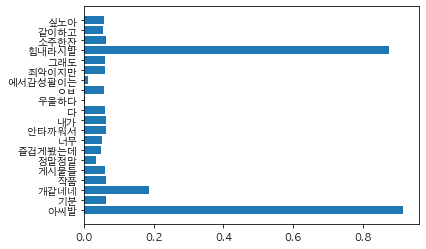

In [327]:

Reference_axis = sentence
Value_axis = []
for i in value:
    if float(i) > 0:
        Value_axis.append((100-float(i))/100)
    else:
        Value_axis.append(-float(i)/100)

Value_axis
plt.figure()
plt.rc('font', family='AppleGothic')
plt.barh(Reference_axis, Value_axis)
plt.show()

In [250]:
for i in range(len(value)):
    if float(value[i]) < 0:
        sentence[i] = format('[CLS]')
sentence

['[CLS]',
 '기분',
 '개같네네',
 '작품',
 '게시물들',
 '정말정말',
 '즐겁게봤는데',
 '너무',
 '안타까워서',
 '내가',
 '다',
 '우울하다',
 'ㅇㅂ',
 '에서감성팔이는',
 '죄악이지만',
 '그래도',
 '[CLS]',
 '소주한잔',
 '같이하고',
 '싶노아']

In [251]:
for j in range(len(sentence)):
    if sentence[j] == '[CLS]':
        sentence[j] = NF[0][random.randint(0, len(NF)-1)]
sentence

#random.randint(0, len(NF)-1)

['멘탈유리병색기야',
 '기분',
 '개같네네',
 '작품',
 '게시물들',
 '정말정말',
 '즐겁게봤는데',
 '너무',
 '안타까워서',
 '내가',
 '다',
 '우울하다',
 'ㅇㅂ',
 '에서감성팔이는',
 '죄악이지만',
 '그래도',
 '지랄발광하는',
 '소주한잔',
 '같이하고',
 '싶노아']

In [139]:

# dataset_test에 부정적인/긍정적인 요소 무작위 추가.
res = []
cnt = 0

for i in range(len(dataset_test['comment'])):
    if dataset_test['label'][i] == 0:
        tmp = ModelToSentence(dataset_test['comment'][i])
        value, sentence = tmp.getWordvalue()
    
        for j in range(len(value)):
            if float(value[j]) < 0:
                sentence[j] = format('[CLS]')
                for k in range(len(sentence)):
                    if sentence[k] == '[CLS]':
                        # 부정 -> NF 긍정 -> PF
                        sentence[k] = NF[0][random.randint(0, len(NF)-1)]
        
        
                    combinedSent = ''
                for i in range(len(sentence)):
                    combinedSent += format(sentence[i] + " ")
            
                res.append(combinedSent)
        cnt = cnt + 1
        if cnt == int(len(dataset_test['comment'])/2):
            print('25%')
            print(res)
        
print('50%')

for i in range(len(dataset_train['comment'])):
    if dataset_train['label'][i] == 0:
        tmp = ModelToSentence(dataset_train['comment'][i])
        value, sentence = tmp.getWordvalue()
    
        for j in range(len(value)):
            if float(value[j]) < 0:
                sentence[j] = format('[CLS]')
                for k in range(len(sentence)):
                    if sentence[k] == '[CLS]':
                        # 부정 -> NF 긍정 -> PF
                        sentence[k] = NF[0][random.randint(0, len(NF)-1)]
        
        
                    combinedSent = ''
                for i in range(len(sentence)):
                    combinedSent += format(sentence[i] + " ")
            
                res.append(combinedSent)
        cnt = cnt + 1
        if cnt == int(len(dataset_train['comment'])/2):
            print('75%')
            print(res)

75%
['면역력 약한 니가족 지랄하는것도 슨타크땜에병 안걸렸을수도 있다 고마운줄 알아라닌 해충 죽일때 죄책감드는 정신 이상자냐 ', '내년에는 꼭 만원으로 올려라 제발 공약 지켜야지원칙을 지키는 게 우선 아닌가근데 좌파들은 그렇게 원칙과 청렴을 따지면서왜 올림픽은 정상적인 절차로 참여도 안한 북한을 참가 시키냐원칙과 절차는 다 보지민국인데 북핵만 막으면 된다는 논리인데그럼 원전이나 박대통령의 독재나 이런 것도 같은 논리 아닌가 ㅋㅋ 잘 살게 됐는데 독재 좀 하면 어떻고 나라에 이익이 오는데 리베이트 좀 하면 어떻냐내로남불일세 ', '2020 없는새끼가 보는사람 ', '치요남 치킨 에게 6000 만원 이라는 거액의 광고비를 받고서도 어덯게 치킨보다 사이드가 맛있는 집 표절 6 단 치킨 호날두가 공뺏긴듯 어설프게 기교부린맛 이딴 식으로 조롱을 할수가 있죠 그 6000 만원 점주들에게 20 만원씩 걷어서 마련한 거란거 애새끼도 그딴식으로 할거면 광고 하지 마세여 보겸님 점주들은 정말 피같은 돈인데 광고 효과가 단 일도 없었다고 하네요 ', '어짜피 시청자들은 자지빨고 무시하고 방송하면 돼요 ㅠㅠ 아프리카 방송부터 팬채팅으로 돌린후 매니저 몇명 구해서 사건언급하는 사람 전부 블랙시키고 차차 복귀각 잡읍시다 ', '시말서 마지막에 안오겠습니다 쿠퍼액같은거 웃기네 ㅋㅋㅋ ', '언제나 인상 찌푸려지게하는 무개념 개씹멀어서가기싫음 ', '내좋아요 빅뱅 1 급식충들은 컴백할 확률 구걸싫으면 내려가고 안눌러도 되요 ', '씹창내는 슈트 카라올린건권지용만 용서할수있다 ', '헐 2017 현지공장이나 바퀴벌래 몰카하실때 처음봤었는데 벌써 2020 시간 빠르네요 재밌게보고갑니다 ㅋㅋㅋ ', '노알라무쿵현따 신께서 노하셨어살풀이를 해야해 그렇지 않으면 더 큰 재앙이말씀이지 1 년내에 ', '노알라무쿵현따 신께서 노하셨어살풀이를 해야해 그렇지 않으면 더 큰 재앙이말씀이지 1 미워하지말아라 ', '양팡 미술학원도 대가리에 ㅋㅋ 양팡이랑 같이 학원 다녔던 분께서 양팡 밀린 학원비 독촉한

In [159]:
# dataset에서 잘못판단한 행 제거.
res = []
cnt = 0

for i in range(len(dataset_test['comment'])):
    if dataset_test['label'][i] == 0:
        tmp = ModelToSentence(dataset_test['comment'][i])
        value, sentence = tmp.getWordvalue()
    
        for j in range(len(value)):
            if float(value[j]) < 0:
                    res.append([i, j])
                    
        cnt = cnt + 1
        if cnt % 100 == 0:
            print(cnt)
        
        
print('50%')
cnt = 0
for i in range(len(dataset_train['comment'])):
    if dataset_train['label'][i] == 0:
        tmp = ModelToSentence(dataset_train['comment'][i])
        value, sentence = tmp.getWordvalue()
    
        for j in range(len(value)):
            if float(value[j]) < 0:
                res.append([i, j])
                
        cnt = cnt + 1
        if cnt % 100 == 0:
            print(cnt)
            
"""     
#len(res) # test_data -> 361개를 잘못판단함.
#len(res) # train_data -> 988개를 잘못 판단함.
T = []
for i in range(988):
    T.append(res[i][0])

dataset_train.drop(T, inplace=True)
dataset_train.to_csv('Dataset_train-v1.txt', sep='\t')
"""


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
50%
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400

In [141]:
# 부정단어사전 저장
NF_dataset = pd.DataFrame({'comment' : res, 'label' : [1 for _ in range(len(res))]})
#PF_dataset = pd.DataFrame({'comment' : res, 'label' : [0 for _ in range(len(res))]})

In [149]:
"""AAA = pd.read_csv('NewNegativeData2.txt')
NF_dataset.to_csv('NewNegativeData3.txt', sep='\t')
#PF_dataset.to_csv('NewPositiveDataset.txt')
# 자연스러운 표현이 생성. <- 내 주관이긴 함.

# 이거 다하면, 기존의 라벨링 수정, 기존의 파일과 병합, 
# 다시 학습해보고, 뭔가 맘에 안들면, 긍정적 사전도 만들어서 병합,
# 그래도 맘에 안들면, 전체적으로 긍정사전 전체로 만들고, 부정사전 전체로 만들어서
# 데이터량을 최대한으로 늘려봅시다.
# 이게 진짜 적절한 예시 
# 나도 의료사고로 병신 됐는데 힘내라 게이야용기내서 글써줘서 고맙다 진짜힘내 
# 나머지는 다 긍정적인 말인데 병신 하나때문에 라벨링이 1로 됐다. 
# 따라서 이 이 병신 부분을 [CLS] 로 처리하고 긍정적인 단어도 넣은 라벨 0을 추가한다.
# 또한 부정적인 것들도 추가한다. 
kk = []
for i in range(len(AAA)):
    kk.append([AAA['comment'][i], AAA['label'][i]])

kk = pd.DataFrame(kk)

kk.to_csv('NewNegativeData2.txt', sep='\t')
"""

# 부정단어 추출

In [41]:
# 부정적 단어 추출.
train_NFactor = []
test_NFactor = []
cnt = 0
for i in range(len(dataset_train)):
    if dataset_train['label'][i] == 1:
        tmp = ModelToSentence(dataset_train['comment'][i])
        NF = returnNFactor(tmp.getWordvalue())
        train_NFactor.append(NF)
        
for i in range(len(dataset_test)):
    if dataset_test['label'][i] == 1:
        tmp = ModelToSentence(dataset_test['comment'][i])
        NF = returnNFactor(tmp.getWordvalue())
        test_NFactor.append(NF)
    
#tmp = ModelToSentence(dataset_train['comment'][0])
#returnNFactor(test.getWordvalue())

In [56]:
NegativeD = []

for i in train_NFactor:
    for j in i:
        NegativeD.append(j)
for i in test_NFactor:
    for j in i:
        NegativeD.append(j)
len(NegativeD)

11103

In [59]:
# 중복제거.
NegativeD = list(set(NegativeD))

In [66]:
NegativeData = pd.DataFrame(NegativeD)

In [68]:
NegativeData.to_excel('/Users/waterpurifier/TextClassification_CNN/Negative_Dict.xlsx')

In [70]:
PreparedNF = pd.read_excel('/Users/waterpurifier/TextClassification_CNN/Negative_Dict_Delete.xlsx')

In [76]:
PreparedNF = PreparedNF.dropna()
del PreparedNF['Unnamed: 0']

In [77]:
PreparedNF.to_excel('/Users/waterpurifier/TextClassification_CNN/NegativeDict.xlsx')

In [79]:
PreparedNF.tail(10)

,0
5159,일뽕새끼들은
5160,오래할거고애새끼
5161,짐승샛끼들임
5163,미친새끼야
5165,존나맞는말
5169,아씨발게이야
5170,탈짱깨
5173,존나높은거지
5176,따먹는거
5178,짱깨가


In [ ]:
# 1. 기존 데이터셋에서 부정적 단어 추출 -> 부정적 단어 사전 구축
# 2. 긍정적 단어 사전 구축
# 3. 일반적인 문장에다가 긍정적 단어, 부정적 단어를 넣어 데이터 양을 늘림.
# ex) 너는 멋쟁이야. -> 너는 [CLS]
# [CLS] : 부정적 단어 -> 라벨 1
# [CLS] : 긍정적 단어 -> 라벨 0


Tokenizer Result  :  ['[CLS]', '병신', '[SEP]'] 

Vetor Result      :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 32447, 3]] 

CNN : 50.90% 확률로 일반적 댓글입니다.

Model Predict     :  50.90177059173584
CNN : 50.90% 확률로 일반적 댓글입니다.

conbination       :  []
Negative Factor   :  []
----------------------------VecToImg----------------------------




Tokenizer Result :  ['너무', '좆', '##같', '##아', '##요', '.', '.'] 

Vetor Result     :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6395, 3309, 4872, 4153, 4150, 18, 18]] 

CNN : 68.11% 확률로 부정적 댓글입니다.

Model Predict    :  -68.1105375289917
CNN : 68.11% 확률로 부정적 댓글입니다.

conbination       :  ['너무좆같아요', '너무..', '좆같아요..', '..좆같아요']
Negative Factor   :  [['너무좆같아요'], [], ['좆같아요'], ['좆같아요']]
----------------------------VecToImg----------------------------






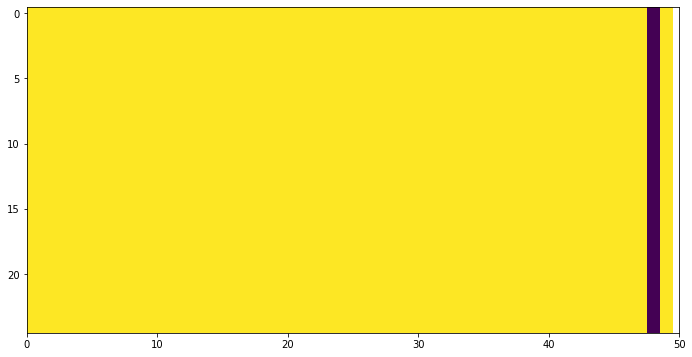

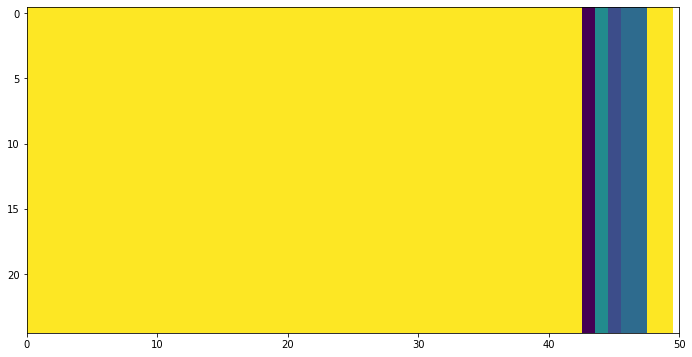

In [27]:
TempText = ModelToSentence('[CLS] 병신 [SEP]')

print(TempText.getSentence())
print("Tokenizer Result  : " , TempText.getTokenizer() , "\n")
print("Vetor Result      : ", TempText.getVector(), "\n") # 1 -> PADDING
print("Model Predict     : ", TempText.sentiment_predict())
conbi = TempText.makeSentence(TempText.sentiment_predict())
print("conbination       : ", conbi)
NFactor = []
for i in conbi:
    tt = ModelToSentence(i)
    NFactor.append(returnNFactor(tt.getWordvalue()))
    
print("Negative Factor   : ", NFactor)

print("----------------------------VecToImg----------------------------\n\n\n\n")
plt.figure(1)
TempText.stshow()

TempText = ModelToSentence('너무 좆같아요..')
print(TempText.getSentence())
print("Tokenizer Result : " , TempText.getTokenizer() , "\n")
print("Vetor Result     : ", TempText.getVector(), "\n") # 1 -> PADDING
print("Model Predict    : ", TempText.sentiment_predict())
conbi = TempText.makeSentence(TempText.sentiment_predict())
print("conbination       : ", conbi)
NFactor = []
for i in conbi:
    tt = ModelToSentence(i)
    NFactor.append(returnNFactor(tt.getWordvalue()))
print("Negative Factor   : ", NFactor)
print("----------------------------VecToImg----------------------------\n\n\n\n")
plt.figure(2)
TempText.stshow()




# 모델 평가

In [449]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

val_pred = loaded_model_CNN.predict(data_train.sentences)

val_predict = []
for i in val_pred:
    if i > 0.5:
        val_predict.append(1)
    else:
        val_predict.append(0)

# f1_score
val_f1 = f1_score(data_train.labels, val_predict)
val_acc = accuracy_score(data_train.labels, val_predict)
val_prec = precision_score(data_train.labels, val_predict)
val_rcall = recall_score(data_train.labels, val_predict)

In [454]:
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (val_acc, val_prec, val_rcall, val_f1))

accuracy = 0.973, precision = 0.955, recall = 0.925, f1 = 0.940


In [2]:
# 모델 테스트
from tensorflow.keras.models import load_model

loaded_model_CNN = load_model('/Users/waterpurifier/CNN_newdata.h5')

In [45]:
# 모델 테스트
from tensorflow.keras.models import load_model

ModelToSentence("존, 나 아파").sentiment_predict()

CNN : 95.41% 확률로 일반적 댓글입니다.



'95.40894627571106'

# ------------------------------------------------